Successfully loaded Csv/F0L.csv
Successfully loaded Csv/F0M.csv
Successfully loaded Csv/F1L.csv
Successfully loaded Csv/F1M.csv
Successfully loaded Csv/F2L.csv
Successfully loaded Csv/F2M.csv
Successfully loaded Csv/F3L.csv
Successfully loaded Csv/F3M.csv
Successfully loaded Csv/F4L.csv
Successfully loaded Csv/F4M.csv
Successfully loaded Csv/F5L.csv
Successfully loaded Csv/F5M.csv
Successfully loaded Csv/F6L.csv
Successfully loaded Csv/F6M.csv
Successfully loaded Csv/F7L.csv
Successfully loaded Csv/F7M.csv

Data loading complete!


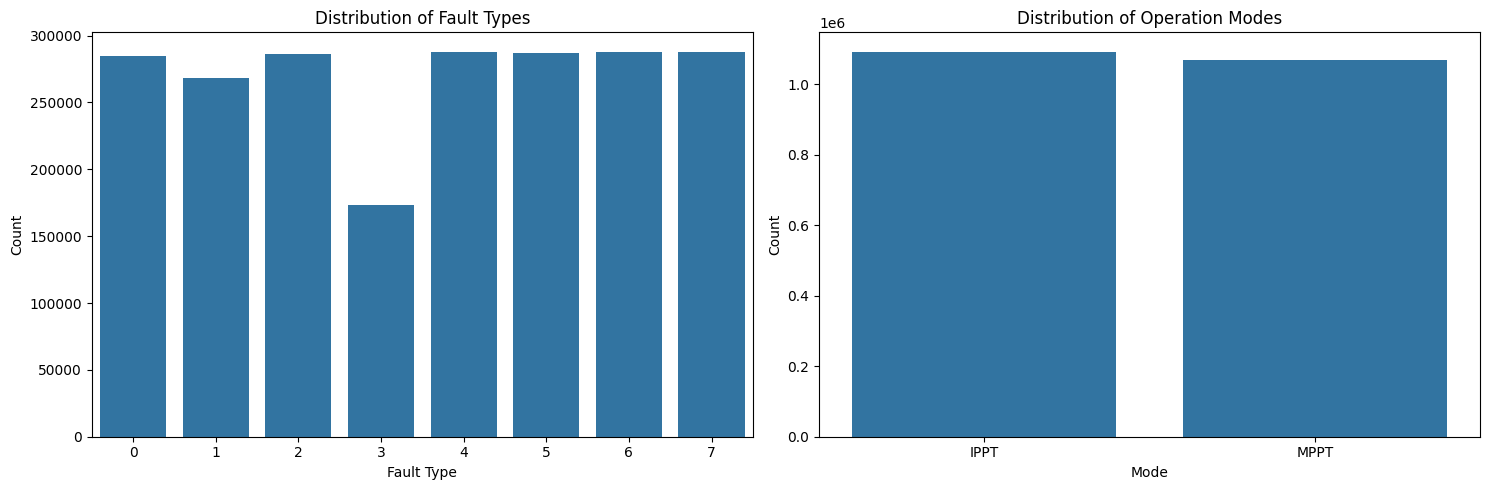


Fault Type Distribution:
Fault_Type
0    284729
1    268027
2    286143
3    173464
4    288028
5    287029
6    288030
7    288030
Name: count, dtype: int64

Mode Distribution:
Mode
IPPT    1093412
MPPT    1070068
Name: count, dtype: int64
Data balanced using min strategy


KeyboardInterrupt: 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
import warnings
import joblib
import os
import json
from datetime import datetime
warnings.filterwarnings('ignore')

class PVFaultAnalysis:
    def __init__(self, csv_folder='Csv', save_dir='saved_models'):
        """
        Initialize the PV Fault Analysis system.
        
        Parameters:
        csv_folder (str): Path to the folder containing CSV files
        save_dir (str): Directory to save model and results
        """
        self.csv_folder = csv_folder
        self.save_dir = save_dir
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.scaler = StandardScaler()
        self.model = None
        self.feature_names = None
        self.training_results = {}
        
        # Create save directory if it doesn't exist
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

    def load_data(self):
        """Load and combine all CSV files."""
        # List of filenames
        csv_files = [
            f'{self.csv_folder}/F{i}{m}.csv' 
            for i in range(8) 
            for m in ['L', 'M']
        ]
        
        data_list = []
        
        for file in csv_files:
            try:
                # Load the CSV file
                df = pd.read_csv(file)
                
                # Extract fault scenario and operation mode
                fault_type = int(file[file.find('F')+1])
                mode = 'MPPT' if 'M' in file else 'IPPT'
                
                # Add columns for fault type and operation mode
                df['Fault_Type'] = fault_type
                df['Mode'] = mode
                
                data_list.append(df)
                print(f"Successfully loaded {file}")
                
            except Exception as e:
                print(f"Error loading {file}: {str(e)}")
        
        # Combine all the data
        self.data = pd.concat(data_list, ignore_index=True)
        print("\nData loading complete!")
        
        return self

    def analyze_data_distribution(self):
        """Analyze and plot the distribution of fault types and modes."""
        plt.figure(figsize=(15, 5))
        
        # Fault type distribution
        plt.subplot(1, 2, 1)
        sns.countplot(data=self.data, x='Fault_Type')
        plt.title('Distribution of Fault Types')
        plt.xlabel('Fault Type')
        plt.ylabel('Count')
        
        # Mode distribution
        plt.subplot(1, 2, 2)
        sns.countplot(data=self.data, x='Mode')
        plt.title('Distribution of Operation Modes')
        plt.xlabel('Mode')
        plt.ylabel('Count')
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed statistics
        print("\nFault Type Distribution:")
        print(self.data['Fault_Type'].value_counts().sort_index())
        print("\nMode Distribution:")
        print(self.data['Mode'].value_counts())
        
        return self

    def balance_data(self, sampling_strategy='min'):
        """
        Balance the dataset using the specified strategy.
        
        Parameters:
        sampling_strategy (str): 'min' for undersampling to minimum class size,
                               'max' for oversampling to maximum class size
        """
        fault_counts = self.data['Fault_Type'].value_counts()
        target_size = fault_counts.min() if sampling_strategy == 'min' else fault_counts.max()
        
        balanced_data = []
        for fault_type in range(8):  # 0 to 7
            fault_data = self.data[self.data['Fault_Type'] == fault_type]
            if len(fault_data) > 0:
                if len(fault_data) > target_size:
                    # Undersample
                    balanced_data.append(fault_data.sample(target_size, random_state=42))
                else:
                    # Oversample if needed
                    balanced_data.append(fault_data.sample(target_size, replace=True, random_state=42))
        
        self.data = pd.concat(balanced_data)
        print(f"Data balanced using {sampling_strategy} strategy")
        return self

    def prepare_features(self):
        """Prepare and scale features for modeling."""
        # Separate features and target
        X = self.data.drop(['Fault_Type', 'Mode'], axis=1)
        self.feature_names = X.columns.tolist()  # Store feature names
        y = self.data['Fault_Type']
        
        # Split the data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Scale the features
        self.X_train = self.scaler.fit_transform(self.X_train)
        self.X_test = self.scaler.transform(self.X_test)
        
        print("Features prepared and scaled")
        return self

    def train_model(self, model_type='rf', tune_hyperparameters=False):
        """Train the selected model and store training parameters."""
        if model_type == 'rf':
            base_model = RandomForestClassifier(random_state=42, class_weight='balanced')
            param_grid = {
                'n_estimators': [100, 200],
                'max_depth': [10, 20, None],
                'min_samples_split': [2, 5],
                'min_samples_leaf': [1, 2]
            }
        elif model_type == 'svm':
            base_model = SVC(random_state=42, class_weight='balanced')
            param_grid = {
                'C': [0.1, 1, 10],
                'kernel': ['rbf', 'linear'],
                'gamma': ['scale', 'auto']
            }
        else:
            raise ValueError("Unsupported model type")
        
        # Store training parameters
        self.training_results['model_type'] = model_type
        self.training_results['hyperparameter_tuning'] = tune_hyperparameters
        
        if tune_hyperparameters:
            print(f"Performing hyperparameter tuning for {model_type}")
            grid_search = GridSearchCV(
                base_model,
                param_grid,
                cv=5,
                scoring='accuracy',
                n_jobs=-1
            )
            grid_search.fit(self.X_train, self.y_train)
            self.model = grid_search.best_estimator_
            self.training_results['best_params'] = grid_search.best_params_
            self.training_results['best_cv_score'] = grid_search.best_score_
            print("Best parameters:", grid_search.best_params_)
            print("Best cross-validation score:", grid_search.best_score_)
        else:
            self.model = base_model
            self.model.fit(self.X_train, self.y_train)
        
        return self

    def evaluate_model(self):
        """Evaluate the trained model and store results."""
        # Make predictions
        y_pred = self.model.predict(self.X_test)
        
        # Calculate and store metrics
        accuracy = accuracy_score(self.y_test, y_pred)
        classification_rep = classification_report(self.y_test, y_pred, output_dict=True)
        confusion_mat = confusion_matrix(self.y_test, y_pred).tolist()
        
        # Store results
        self.training_results.update({
            'accuracy': accuracy,
            'classification_report': classification_rep,
            'confusion_matrix': confusion_mat
        })
        
        # Display results
        print("\nModel Evaluation Results:")
        print("Accuracy:", accuracy)
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred))
        
        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()
        
        # Perform and store cross-validation results
        cv_scores = cross_val_score(
            self.model, self.X_train, self.y_train, 
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        )
        self.training_results['cv_scores'] = cv_scores.tolist()
        self.training_results['cv_mean'] = cv_scores.mean()
        self.training_results['cv_std'] = cv_scores.std()
        
        print("\nCross-validation scores:", cv_scores)
        print("Mean CV score:", cv_scores.mean())
        print("Standard deviation:", cv_scores.std())
        
        return self

    def analyze_feature_importance(self):
        """Analyze and plot feature importance (for Random Forest only)."""
        if isinstance(self.model, RandomForestClassifier):
            # Get feature importance
            importance = self.model.feature_importances_
            
            # Create DataFrame and sort
            feature_importance = pd.DataFrame({
                'feature': self.feature_names,
                'importance': importance
            }).sort_values('importance', ascending=False)
            
            # Plot
            plt.figure(figsize=(12, 6))
            sns.barplot(data=feature_importance.head(10), 
                       x='importance', y='feature')
            plt.title('Top 10 Most Important Features')
            plt.xlabel('Importance')
            plt.tight_layout()
            plt.show()
            
            print("\nTop 10 most important features:")
            print(feature_importance.head(10))
            
            # Store feature importance in results
            self.training_results['feature_importance'] = feature_importance.to_dict('records')
        else:
            print("Feature importance analysis is only available for Random Forest model")
        
        return self

    def save_results(self, model_name=None):
        """
        Save the trained model, scaler, and results.
        
        Parameters:
        model_name (str): Optional custom name for the saved model
        """
        if self.model is None:
            raise ValueError("No trained model to save")
        
        # Generate timestamp-based name if none provided
        if model_name is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            model_name = f"pv_fault_model_{timestamp}"
        
        # Create model directory
        model_dir = os.path.join(self.save_dir, model_name)
        os.makedirs(model_dir, exist_ok=True)
        
        # Save model and scaler
        joblib.dump(self.model, os.path.join(model_dir, 'model.joblib'))
        joblib.dump(self.scaler, os.path.join(model_dir, 'scaler.joblib'))
        
        # Save feature names
        with open(os.path.join(model_dir, 'feature_names.json'), 'w') as f:
            json.dump(self.feature_names, f)
        
        # Save training results
        with open(os.path.join(model_dir, 'training_results.json'), 'w') as f:
            json.dump(self.training_results, f)
        
        print(f"\nModel and results saved in: {model_dir}")
        return self

    @classmethod
    def load_saved_model(cls, model_dir):
        """
        Load a saved model and its associated data.
        
        Parameters:
        model_dir (str): Directory containing the saved model
        
        Returns:
        PVFaultAnalysis: Instance with loaded model and data
        """
        instance = cls()
        
        # Load model and scaler
        instance.model = joblib.load(os.path.join(model_dir, 'model.joblib'))
        instance.scaler = joblib.load(os.path.join(model_dir, 'scaler.joblib'))
        
        # Load feature names
        with open(os.path.join(model_dir, 'feature_names.json'), 'r') as f:
            instance.feature_names = json.load(f)
        
        # Load training results
        with open(os.path.join(model_dir, 'training_results.json'), 'r') as f:
            instance.training_results = json.load(f)
        
        print(f"Model loaded from: {model_dir}")
        return instance

    def predict(self, X):
        """
        Make predictions using the loaded model.
        
        Parameters:
        X (array-like): Features to predict
        
        Returns:
        array: Predicted fault types
        """
        if self.model is None:
            raise ValueError("No model loaded")
        
        # Scale the input features
        X_scaled = self.scaler.transform(X)
        
        # Make predictions
        return self.model.predict(X_scaled)

# Usage example
def main():
    # Initialize and run the analysis
    analyzer = PVFaultAnalysis()
    
    # Run the complete analysis pipeline
    (analyzer
     .load_data()
     .analyze_data_distribution()
     .balance_data()
     .prepare_features()
     .train_model(model_type='rf', tune_hyperparameters=True)
     .evaluate_model()
     .analyze_feature_importance()
     .save_results())  # Save the results
    
    # Example of loading and using a saved model
    # saved_model_dir = 'saved_models/your_model_name'
    # loaded_analyzer = PVFaultAnalysis.load_saved_model(saved_model_dir)
    # new_data = pd.DataFrame(...)  # Your new data
    # predictions = loaded_analyzer.predict(new_data)

if __name__ == "__main__":
    main()

Use Saved Data


In [ ]:
# Load the saved model
loaded_analyzer = PVFaultAnalysis.load_saved_model('saved_models/your_model_name')

# Make predictions with new data
new_data = pd.DataFrame(...)  # Your new data
predictions = loaded_analyzer.predict(new_data)

# Access saved training results
print(loaded_analyzer.training_results['accuracy'])
print(loaded_analyzer.training_results['best_params'])

In [ ]:
# Train and save a model
analyzer = PVFaultAnalysis()
analyzer.load_data().prepare_features().train_model().save_results()

# Later, load and use the saved model
saved_model_dir = 'saved_models/pv_fault_model_20240123_120000'  # Use your actual saved model directory
loaded_analyzer = PVFaultAnalysis.load_saved_model(saved_model_dir)